In this notebook we shall present a simple conditional VAE, trained on MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

The conditional autoencoder will allow to generate specific digits in the MNIST range 0-9. The condition is passed as input to encoder and decoder in categorical format.

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

# The model

Sampling function for the Variational Autoencoder.
This is the closed form of the Kullback-Leibler distance between a gaussian N(z_mean,z_var) and a normal prior N(0,1)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.) # gaussian random variable with mean 0 and std 1
    return z_mean + K.exp(z_log_var / 2) * epsilon 

Main dimensions for the model (a simple stack of dense layers).

In [5]:
input_dim = 784
latent_dim = 8
intermediate_dim = 25

We start with the encoder. It takes two inputs: the image and the category.

It returns the latent encoding (z_mean) and a (log-)variance for each latent variable.

In [6]:
x = layers.Input(shape=(input_dim,))
y = layers.Input(shape=(10,)) # one-hot encoding of the category 0-9
xy = layers.concatenate([x,y])
h = layers.Dense(intermediate_dim, activation='relu')(xy)
z_mean = layers.Dense(latent_dim)(h) # mean 
z_log_var = layers.Dense(latent_dim)(h) # log variance 

Now we sample around z_mean with the associated variance. 

Note the use of the "lambda" layer to transform the sampling function into a keras layer.

In [7]:
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

Now we need to address the decoder. We first define its layers, in order to use them both in the vae model and in the stand-alone generator.

In [8]:
decoder_mid = layers.Dense(intermediate_dim, activation='relu')
decoder_out = layers.Dense(input_dim, activation='sigmoid')

We decode the image starting from the latent representation z and its category y, that must be concatenated.

In [9]:
zy = layers.concatenate([z,y]) # ocncatenate z with one-hot encoding of the category 0-9
dec_mid = decoder_mid(zy)
x_hat = decoder_out(dec_mid)

vae = Model(inputs=[x,y], outputs=[x_hat])

Some hyperparameters. Gamma is used to balance loglikelihood and KL-divergence in the loss function

In [10]:
batch_size = 100
epochs = 50
gamma = .5

The VAE loss function is just the sum between the reconstruction error (mse or bce) and the KL-divergence, acting as a regularizer of the latent space.

In [14]:
from keras.losses import binary_crossentropy

rec_loss = input_dim * binary_crossentropy(x, x_hat)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rec_loss + gamma*kl_loss)
vae.add_loss(vae_loss)

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


We are ready to compile. There is no need to specify the loss function, since we already added it to the model with add_loss.

In [12]:
vae.compile(optimizer='adam')

Train for a sufficient amount of epochs. Generation is a more complex task than classification.

In [13]:
vae.fit([x_train,y_train], shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=([x_test,y_test], None))

vae.save_weights("cvae256_8.h5")

Epoch 1/50


ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

Let us decode the full training set.

In [93]:
decoded_imgs = vae.predict([x_test,y_test])

The following function is to test the quality of reconstructions (not particularly good, since compression is strong).

In [96]:
def plot(n=10): # plot the first n test digits and their reconstructions
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28)) # original 
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28)) # reconstruction
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

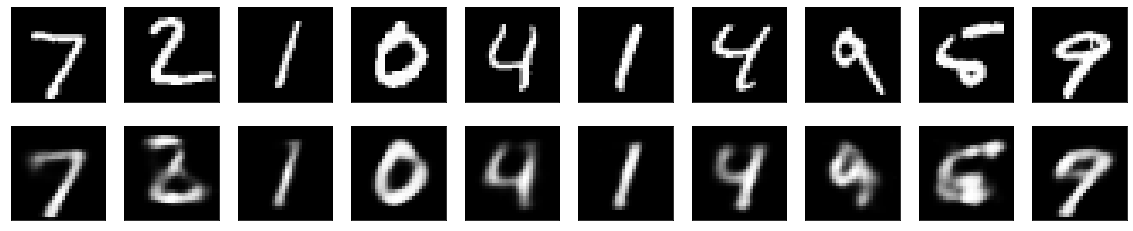

In [94]:
plot()

Finally, we build a digit generator that can sample from the learned distribution

In [15]:
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(10,))
xy = layers.concatenate([noise,label])
dec_mid = decoder_mid(xy)
dec_out = decoder_out(dec_mid)
generator = Model([noise,label],dec_out)

And we can generate our samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

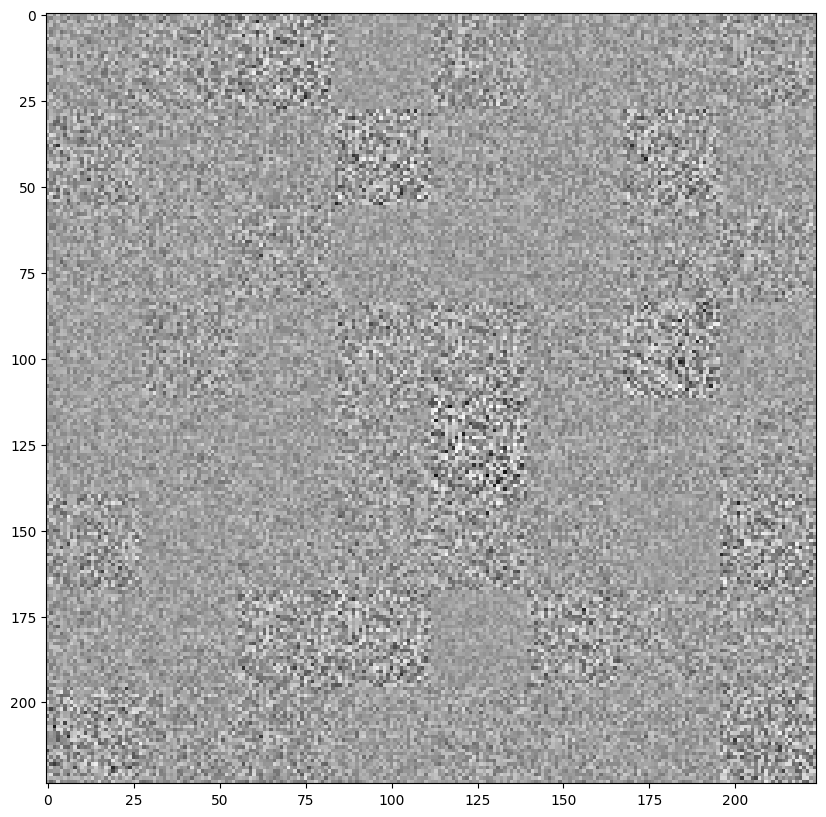

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

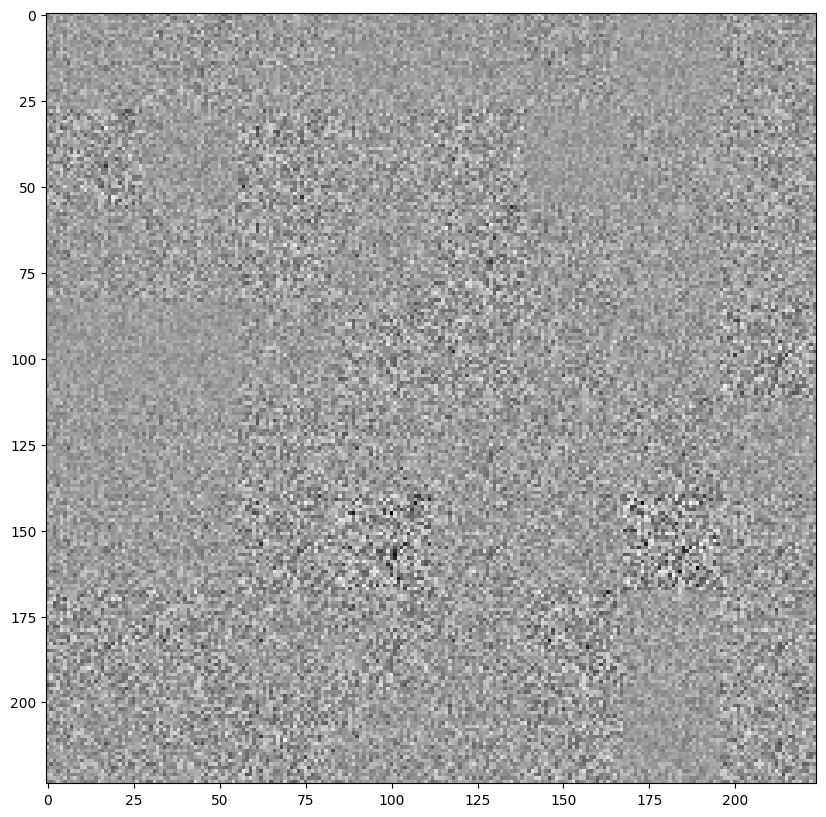

ValueError: invalid literal for int() with base 10: ''

In [16]:
import time
# display a 2D manifold of the digits
n = 8  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

while True:
  label = input("input digit to generate: ")
  label = int(label)
  if label < 0 or label > 9:
      print(label)
      break
  label = np.expand_dims(utils.to_categorical(label,10),axis=0) # one-hot encoding
  for i in range(0,n):
    for j in range (0,n):
        z_sample = np.expand_dims(np.random.normal(size=latent_dim),axis=0) # sample from the latent space 
        x_decoded = generator.predict([z_sample,label]) # reconstruct the image
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
  plt.figure(figsize=(10, 10))
  plt.imshow(figure, cmap='Greys_r')
  plt.show()
  time.sleep(1)